In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision
import cv2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 0. Import Data

In [2]:
challenges = pd.read_csv('data/challenges.csv')
challenges.head()

,folder,image_name
0,jerry,frame360.jpg
1,jerry,frame1794.jpg
2,jerry,frame1795.jpg
3,jerry,frame2231.jpg
4,jerry,frame2234.jpg


In [3]:
data = pd.read_csv('data/ground_truth.csv')
data['filepath'] = 'data/all_pics/' + data['filename']
label = []
for i in range(len(data)):
    if data.iloc[i].tom == 0 and data.iloc[i].jerry == 0:
        label.append(0)
    elif data.iloc[i].tom == 1 and data.iloc[i].jerry == 0:
        label.append(1)
    elif data.iloc[i].tom == 0 and data.iloc[i].jerry == 1:
        label.append(2)
    else:
        label.append(3)
data['label'] = label

data

,filename,tom,jerry,filepath,label
0,frame0.jpg,0,0,data/all_pics/frame0.jpg,0
1,frame1.jpg,0,0,data/all_pics/frame1.jpg,0
2,frame2.jpg,0,0,data/all_pics/frame2.jpg,0
3,frame3.jpg,0,0,data/all_pics/frame3.jpg,0
4,frame4.jpg,0,0,data/all_pics/frame4.jpg,0
...,...,...,...,...,...
5473,frame5473.jpg,0,0,data/all_pics/frame5473.jpg,0
5474,frame5474.jpg,0,0,data/all_pics/frame5474.jpg,0
5475,frame5475.jpg,0,0,data/all_pics/frame5475.jpg,0
5476,frame5476.jpg,0,0,data/all_pics/frame5476.jpg,0


In [4]:
data.groupby('tom').count()

,filename,jerry,filepath,label
tom,,,,
0,2768,2768,2768,2768
1,2710,2710,2710,2710


In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

i = np.random.rand(5478)
df_train = data.iloc[i>0.25].reset_index(drop=True)
df_val = data.iloc[i<=0.25].reset_index(drop=True)

In [6]:
df_train.shape, df_val.shape

((4071, 5), (1407, 5))

In [7]:
df_train

,filename,tom,jerry,filepath,label
0,frame0.jpg,0,0,data/all_pics/frame0.jpg,0
1,frame1.jpg,0,0,data/all_pics/frame1.jpg,0
2,frame2.jpg,0,0,data/all_pics/frame2.jpg,0
3,frame3.jpg,0,0,data/all_pics/frame3.jpg,0
4,frame6.jpg,0,0,data/all_pics/frame6.jpg,0
...,...,...,...,...,...
4066,frame5472.jpg,0,1,data/all_pics/frame5472.jpg,2
4067,frame5474.jpg,0,0,data/all_pics/frame5474.jpg,0
4068,frame5475.jpg,0,0,data/all_pics/frame5475.jpg,0
4069,frame5476.jpg,0,0,data/all_pics/frame5476.jpg,0


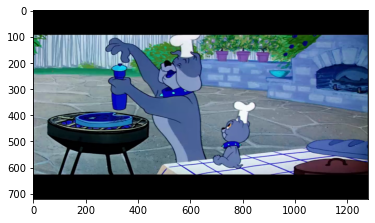

In [8]:
img = cv2.imread('data/all_pics/frame0.jpg')
# img
plt.imshow(img)

In [9]:
img = cv2.imread('data/all_pics/frame0.jpg')
# resize the img
img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # move color channels to correct spot
img = np.transpose(img, (2, 0, 1))

In [10]:
img = torch.tensor(img).float()

In [11]:
img.shape

torch.Size([3, 128, 128])

In [12]:
img = img[np.newaxis, :, :, :]
img.shape

torch.Size([1, 3, 128, 128])

# 1. Create the CNN model

In [13]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(4096, 100)
        self.linear2 = nn.Linear(100, 1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.relu(self.linear1(self.unroll(x)))
        x = self.linear2(x)
        return torch.squeeze(x)

In [14]:
class Multi_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(4096, 100)
        self.linear2 = nn.Linear(100, 4)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.relu(self.linear1(self.unroll(x)))
        x = self.linear2(x)
        return x

# 2. Train & Evaluation Functions

In [15]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc_multi(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

def one_pass_acc_simple(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    for x, y in dataloader:
        y_pred = model(x)
        y_pred = (torch.sigmoid(y_pred) > 0.5).float()
        
        total_incorrect = torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

# 3. Binary Prediction

## 3.1 Predict Tom

### 3.1.1 Create Dataset

In [16]:
# Dataset with resizing option
class TomDataset(Dataset):
    def __init__(self, df, data_path, resize=False):
        self.df = df
        self.data_path = data_path
        self.resize = resize
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        

        image_path = row['filepath']
        
        # read the img
        img = cv2.imread(image_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize image
        if self.resize == True:
            img = cv2.resize(img, (128, 128))
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(row['tom']).float()
        
        return img, label

In [17]:
data_path = 'data/all_pics'

In [18]:
ds_train = TomDataset(df_train, data_path, resize=True)
ds_val = TomDataset(df_val, data_path, resize=True)

dl_train = DataLoader(ds_train, batch_size=500, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=500, shuffle=False)

### 3.1.2 Create Model

In [19]:
tom_model = Simple_CNN()

from torchsummary import summary
summary(tom_model, input_size = (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [20]:
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(tom_model.parameters(), lr = 0.001)

### 3.3.2 Train & Evaluate

In [21]:
from tqdm.notebook import tqdm

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(tom_model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(tom_model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc_simple(tom_model, dl_train, len(ds_train))
    valid_acc = one_pass_acc_simple(tom_model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0
Train loss:  0.6947364343537225
Valid loss:  0.6935563683509827
Train Acc:  0.9926308032424466
Valid Acc:  0.8450604122245913
Epoch:  1
Train loss:  0.6925991574923197
Valid loss:  0.6920741597811381
Train Acc:  0.9916482436747728
Valid Acc:  0.8450604122245913
Epoch:  2
Train loss:  0.6844204995367262
Valid loss:  0.6742121974627177
Train Acc:  0.9958241218373864
Valid Acc:  0.8941009239516702
Epoch:  3
Train loss:  0.6613319714864095
Valid loss:  0.6392198204994202
Train Acc:  0.9928764431343651
Valid Acc:  0.9111584932480454
Epoch:  4
Train loss:  0.6206745240423415
Valid loss:  0.6007668574651083
Train Acc:  0.9938590027020389
Valid Acc:  0.9118692253020612
Epoch:  5
Train loss:  0.5852943592601352
Valid loss:  0.5737798810005188
Train Acc:  0.995087202161631
Valid Acc:  0.9097370291400142
Epoch:  6
Train loss:  0.5456250276830461
Valid loss:  0.5464006066322327
Train Acc:  0.9953328420535495
Valid Acc:  0.9111584932480454
Epoch:  7
Train loss:  0.501594967312283
Valid lo

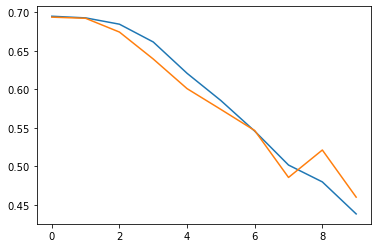

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

## 3.2 Predict Jerry

### 3.2.1 Create Dataset

In [23]:
# Dataset with resizing option
class JerryDataset(Dataset):
    def __init__(self, df, data_path, resize=False):
        self.df = df
        self.data_path = data_path
        self.resize = resize
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        

        image_path = row['filepath']
        
        # read the img
        img = cv2.imread(image_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize image
        if self.resize == True:
            img = cv2.resize(img, (128, 128))
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(row['jerry']).float()
        
        return img, label

In [24]:
ds_train = JerryDataset(df_train, data_path, resize=True)
ds_val = JerryDataset(df_val, data_path, resize=True)

dl_train = DataLoader(ds_train, batch_size=500, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=500, shuffle=False)

### 3.2.2 Create Model

In [25]:
jerry_model = Simple_CNN()

from torchsummary import summary
summary(jerry_model, input_size = (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [26]:
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(jerry_model.parameters(), lr = 0.001)

### 3.3.3 Train & Evaluate

In [27]:
from tqdm.notebook import tqdm

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(jerry_model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(jerry_model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc_simple(jerry_model, dl_train, len(ds_train))
    valid_acc = one_pass_acc_simple(jerry_model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0
Train loss:  0.6568315029144287
Valid loss:  0.6587000290552775
Train Acc:  0.9921395234586097
Valid Acc:  0.9019189765458422
Epoch:  1
Train loss:  0.6506916350788541
Valid loss:  0.6565801898638407
Train Acc:  0.9965610415131417
Valid Acc:  0.9019189765458422
Epoch:  2
Train loss:  0.6476842761039734
Valid loss:  0.6542935570081075
Train Acc:  0.9928764431343651
Valid Acc:  0.9019189765458422
Epoch:  3
Train loss:  0.6448764801025391
Valid loss:  0.6496100823084513
Train Acc:  0.9938590027020389
Valid Acc:  0.9026297085998578
Epoch:  4
Train loss:  0.6385629971822103
Valid loss:  0.641680379708608
Train Acc:  0.9923851633505282
Valid Acc:  0.8997867803837953
Epoch:  5
Train loss:  0.6366277933120728
Valid loss:  0.64426589012146
Train Acc:  0.9923851633505282
Valid Acc:  0.900497512437811
Epoch:  6
Train loss:  0.6361610492070516
Valid loss:  0.6405168374379476
Train Acc:  0.9960697617293048
Valid Acc:  0.9026297085998578
Epoch:  7
Train loss:  0.6336281895637512
Valid loss

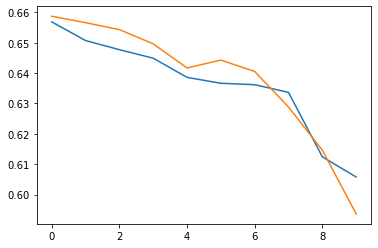

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

# 2. Multi-Class Prediction

## 2.1 Create Dataset

In [29]:
# Dataset with resizing option
class CombinedDataset(Dataset):
    def __init__(self, df, data_path, resize=False):
        self.df = df
        self.data_path = data_path
        self.resize = resize
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        

        image_path = row['filepath']
        
        # read the img
        img = cv2.imread(image_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize image
        if self.resize == True:
            img = cv2.resize(img, (128, 128))
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(row['label'])
        
        return img, label

In [30]:
data_path = 'data/all_pics'

In [35]:
ds_train = CombinedDataset(df_train, data_path, resize=True)
ds_val = CombinedDataset(df_val, data_path, resize=True)

dl_train = DataLoader(ds_train, batch_size=8, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=20, shuffle=False)

## 2.2 Create Model

In [36]:
combined_model = Multi_CNN()

from torchsummary import summary
summary(combined_model, input_size = (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [37]:
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr = 0.001)

## 2.3 Train & Evaluation

In [38]:
from tqdm.notebook import tqdm

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(combined_model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(combined_model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc_multi(combined_model, dl_train, len(ds_train))
    valid_acc = one_pass_acc_multi(combined_model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0
Train loss:  1.3191864001024918
Valid loss:  1.1698431364247497
Train Acc:  0.47433063129452224
Valid Acc:  0.4584221748400853
Epoch:  1
Train loss:  1.0140687051011443
Valid loss:  0.9470926951354658
Train Acc:  0.6322770817980841
Valid Acc:  0.589907604832978
Epoch:  2
Train loss:  0.7865922335967099
Valid loss:  0.7927090408096851
Train Acc:  0.7479734708916728
Valid Acc:  0.6872778962331201
Epoch:  3
Train loss:  0.590767656363298
Valid loss:  0.7315084476706007
Train Acc:  0.8197003193318595
Valid Acc:  0.7121535181236673
Epoch:  4
Train loss:  0.4530680836974286
Valid loss:  0.6916070893196993
Train Acc:  0.8727585359862442
Valid Acc:  0.7327647476901209
Epoch:  5
Train loss:  0.35622126475884075
Valid loss:  0.6424253834805018
Train Acc:  0.9164824367477278
Valid Acc:  0.7739872068230277
Epoch:  6
Train loss:  0.2790317717346789
Valid loss:  0.6750255413878132
Train Acc:  0.9287644313436502
Valid Acc:  0.7818052594171997
Epoch:  7
Train loss:  0.21641270118383124
Valid

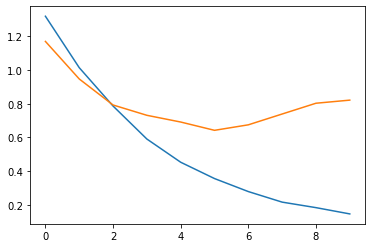

In [39]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

# 3. Challenges

In [40]:
challenges = pd.read_csv('data/challenges.csv')
challenges.head()

,folder,image_name
0,jerry,frame360.jpg
1,jerry,frame1794.jpg
2,jerry,frame1795.jpg
3,jerry,frame2231.jpg
4,jerry,frame2234.jpg


In [41]:
challenges['filepath'] = 'data/all_pics/' + challenges['image_name']
label = []
tom = []
jerry = []
for i in range(len(challenges)):
    if challenges.iloc[i].folder == 'tom':
        tom.append(1)
        jerry.append(0)
        label.append(1)
    else:
        tom.append(0)
        jerry.append(1)
        label.append(2)
challenges['tom'] = tom
challenges['jerry'] = jerry
challenges['label'] = label
challenges

,folder,image_name,filepath,tom,jerry,label
0,jerry,frame360.jpg,data/all_pics/frame360.jpg,0,1,2
1,jerry,frame1794.jpg,data/all_pics/frame1794.jpg,0,1,2
2,jerry,frame1795.jpg,data/all_pics/frame1795.jpg,0,1,2
3,jerry,frame2231.jpg,data/all_pics/frame2231.jpg,0,1,2
4,jerry,frame2234.jpg,data/all_pics/frame2234.jpg,0,1,2
5,jerry,frame2941.jpg,data/all_pics/frame2941.jpg,0,1,2
6,jerry,frame2942.jpg,data/all_pics/frame2942.jpg,0,1,2
7,jerry,frame2943.jpg,data/all_pics/frame2943.jpg,0,1,2
8,jerry,frame2944.jpg,data/all_pics/frame2944.jpg,0,1,2
9,jerry,frame5399.jpg,data/all_pics/frame5399.jpg,0,1,2


In [42]:
data_path = 'data/all_pics'

## 3.1 Tom

In [43]:
ds_tom = TomDataset(challenges, data_path, resize=True)
dl_tom = DataLoader(ds_tom, batch_size=500, shuffle=False)

In [44]:
one_pass_acc_simple(tom_model, dl_tom, len(ds_tom))

0.75

## 3.2 Jerry

In [45]:
ds_jerry = JerryDataset(challenges, data_path, resize=True)
dl_jerry = DataLoader(ds_jerry, batch_size=500, shuffle=False)

In [46]:
one_pass_acc_simple(jerry_model, dl_jerry, len(ds_jerry))

0.65625

## 3.3 Combined

In [47]:
ds_combined = CombinedDataset(challenges, data_path, resize=True)
dl_combined = DataLoader(ds_combined, batch_size=500, shuffle=False)

In [49]:
one_pass_acc_multi(combined_model, dl_combined, len(ds_combined))

1.0